# 2022-03-28 Gradient Descent

## Last time

* Assumptions of linear models
* Look at your data!
* Partial derivatives
* Loss functions

## Today

* Discuss projects
* Gradient-based optimization for linear models
* Nonlinear models

In [3]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

# Workshopping projects today

* Maybe you've started, maybe you're still looking for a good project
* What have you been thinking about?
* What do you need help on?

## Each breakout group will report out
1. One interesting thing about process
2. One question you have relevant to the projects (specific or general)
3. One question from content we've covered

# Variational notation for derivatives

It's convenient to express derivatives in terms of how they act on an infinitessimal perturbation. So we might write

$$ \delta f = \frac{\partial f}{\partial x} \delta x .$$

(It's common to use $\delta x$ or $dx$ for these infinitesimals.) This makes inner products look like a normal product rule

$$ \delta(\mathbf x^T \mathbf y) = \mathbf y^T (\delta \mathbf x) + \mathbf x^T (\delta \mathbf y). $$

A powerful example of variational notation is differentiating a matrix inverse

$$ 0 = \delta I = \delta(A^{-1} A) = (\delta A^{-1}) A + A^{-1} (\delta A) $$
and thus
$$ \delta A^{-1} = - A^{-1} (\delta A) A^{-1} $$

# Optimization for linear models
Given data $(x,y)$ and loss function $L(c; x,y)$, we wish to find the coefficients $c$ that minimize the loss, thus yielding the "best predictor" (in a sense that can be made statistically precise).  I.e.,
$$ \bar c = \arg\min_c L(c; x,y) . $$

It is usually desirable to design models such that the loss function is differentiable with respect to the coefficients $c$, because this allows the use of more efficient optimization methods.  Recall that our forward model is given in terms of the Vandermonde matrix,

$$ f(x, c) = V(x) c $$

and thus

$$ \frac{\partial f}{\partial c} = V(x) . $$

# Derivative of loss function

We now differentiate our loss function
$$ L(c; x, y) = \frac 1 2 \lVert f(x, c) - y \rVert^2 $$
using a more linear algebraic approach to write the same expression is
\begin{align} \nabla_c L(c; x,y) &= \big( f(x,c) - y \big)^T V(x) \\
&= \big(V(x) c - y \big)^T V(x) \\
&= V(x)^T \big( V(x) c - y \big) .
\end{align}
A necessary condition for the loss function to be minimized is that $\nabla_c L(c; x,y) = 0$.

* Is the condition sufficient for general $f(x, c)$?
* Is the condition sufficient for the linear model $f(x,c) = V(x) c$?
* Have we seen this sort of equation before?

## Gradient descent

Instead of solving the least squares problem using linear algebra (QR factorization), we could solve it using gradient descent.  That is, on each iteration, we'll take a step in the direction of the negative gradient.

In [17]:
function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

## Quadratic model

cond(A) = 9.46578492882319


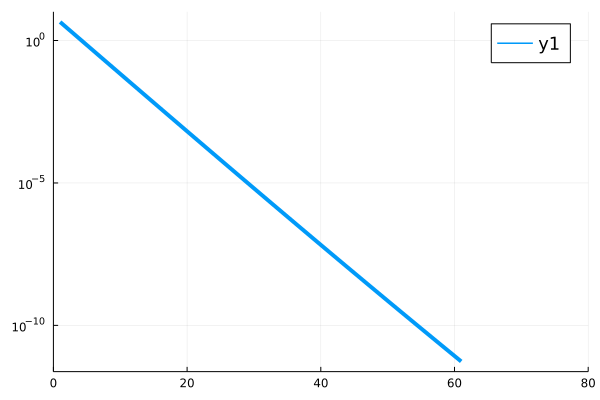

In [62]:
A = [1 1; 1 8]
@show cond(A)
loss(c) = .5 * c' * A * c
grad(c) = A * c

c, chist, lhist = grad_descent(loss, grad, [.9, .9],
    gamma=.22)
plot(lhist, yscale=:log10, xlims=(0, 80))

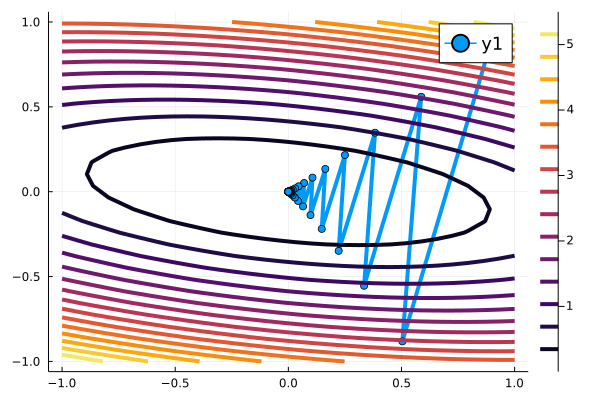

In [61]:
plot(chist[1, :], chist[2, :], marker=:circle)
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

# Chebyshev regression via optimization



In [63]:
x = LinRange(-1, 1, 200)
sigma = 0.5; n = 8
y = runge_noisy(x, sigma)
V = vander(x, n)
function loss(c)
    r = V * c - y
    .5 * r' * r
end
function grad(c)
    r = V * c - y
    V' * r
end
c, _, lhist = grad_descent(loss, grad, ones(n),
    gamma=0.008)
c

8-element Vector{Float64}:
  0.7891712932446856
  0.007025641791364225
 -1.957064629386119
 -0.36715187386667464
  0.9229823103908219
  0.3031710357963882
  0.4284481908323782
  0.27267026221101087

cond(V' * V) = 52902.52994792479


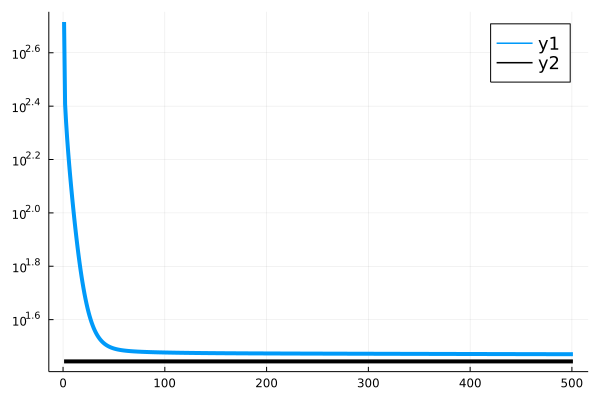

In [65]:
c0 = V \ y
l0 = 0.5 * norm(V * c0 - y)^2
@show cond(V' * V)
plot(lhist, yscale=:log10)
plot!(i -> l0, color=:black)

# Why use QR vs gradient-based optimization?

# Nonlinear models

Instead of the linear model
$$ f(x,c) = V(x) c = c_0 + c_1 \underbrace{x}_{T_1(x)} + c_2 T_2(x) + \dotsb $$
let's consider a rational model with only three parameters
$$ f(x,c) = \frac{1}{c_1 + c_2 x + c_3 x^2} = (c_1 + c_2 x + c_3 x^2)^{-1} . $$
We'll use the same loss function
$$ L(c; x,y) = \frac 1 2 \lVert f(x,c) - y \rVert^2 . $$

We will also need the gradient
$$ \nabla_c L(c; x,y) = \big( f(x,c) - y \big)^T \nabla_c f(x,c) $$
where
\begin{align}
\frac{\partial f(x,c)}{\partial c_1} &= -(c_1 + c_2 x + c_3 x^2)^{-2} = - f(x,c)^2 \\
\frac{\partial f(x,c)}{\partial c_2} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x = - f(x,c)^2 x \\
\frac{\partial f(x,c)}{\partial c_3} &= -(c_1 + c_2 x + c_3 x^2)^{-2} x^2 = - f(x,c)^2 x^2 .
\end{align}

# Fitting a rational function

In [12]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)
function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end
function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end
function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

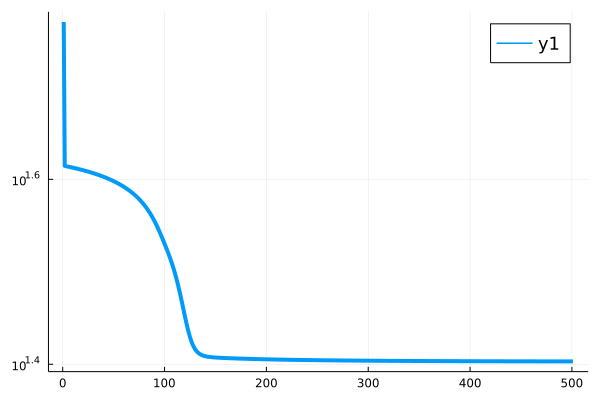

In [13]:
c, _, lhist = grad_descent(loss, gradient, ones(3), gamma=8e-2)
plot(lhist, yscale=:log10)

# Compare fits on noisy data

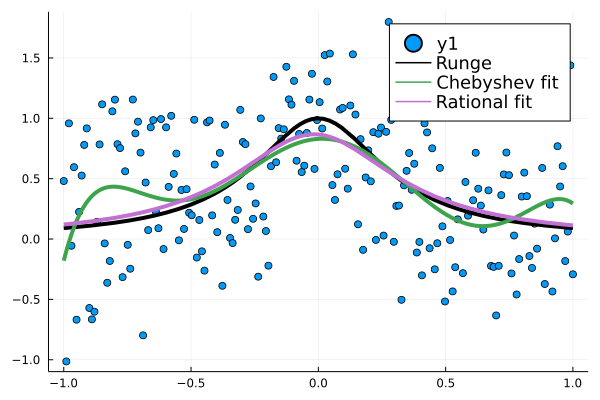

In [16]:
scatter(x, y)
V = vander_chebyshev(x, 7)
plot!(x -> runge(x), color=:black, label="Runge")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")